### Import libraries

In [1]:
import sys
sys.path.insert(0, '../backend')
sys.path.insert(0, '../../data')

import numpy as np
import pandas as pd
from collections import defaultdict
import random
import math
import pybnb
from tqdm import tqdm_notebook as tqdm

from branch_and_bound_warped_pvar_sequential import BnBWarping
from generalized_dtw import Warp
from transformers import *

from sklearn import decomposition
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from sklearn.manifold import MDS, TSNE

import plotly.plotly as py
import plotly.graph_objs as go
import plotly

import matplotlib.pyplot as plt
%matplotlib inline

# Brownian paths simulation

In [2]:
def white(steps, width, time=1.):
    mu, sigma = 0, math.sqrt(time / steps) 
    return np.random.normal(mu, sigma, (steps, width))

def brownian(steps, width, time=1.):
    path = np.zeros((steps + 1, width))
    np.cumsum(white(steps, width, time), axis=0, out=path[1:, :])
    return path

# k-Menoids clustering function

In [3]:
def cluster(distances, k=3):

    m = distances.shape[0] # number of points

    # Pick k random medoids.
    curr_medoids = np.array([-1]*k)
    while not len(np.unique(curr_medoids)) == k:
        curr_medoids = np.array([random.randint(0, m - 1) for _ in range(k)])
    old_medoids = np.array([-1]*k) # Doesn't matter what we initialize these to.
    new_medoids = np.array([-1]*k)
   
    # Until the medoids stop updating, do the following:
    while not ((old_medoids == curr_medoids).all()):
        # Assign each point to cluster with closest medoid.
        clusters = assign_points_to_clusters(curr_medoids, distances)

        # Update cluster medoids to be lowest cost point. 
        for curr_medoid in curr_medoids:
            cluster = np.where(clusters == curr_medoid)[0]
            new_medoids[curr_medoids == curr_medoid] = compute_new_medoid(cluster, distances)

        old_medoids[:] = curr_medoids[:]
        curr_medoids[:] = new_medoids[:]

    return clusters, curr_medoids

def assign_points_to_clusters(medoids, distances):
    distances_to_medoids = distances[:,medoids]
    clusters = medoids[np.argmin(distances_to_medoids, axis=1)]
    clusters[medoids] = medoids
    return clusters

def compute_new_medoid(cluster, distances):
    mask = np.ones(distances.shape)
    mask[np.ix_(cluster,cluster)] = 0.
    cluster_distances = np.ma.masked_array(data=distances, mask=mask, fill_value=10e9)
    costs = cluster_distances.sum(axis=1)
    return costs.argmin(axis=0, fill_value=10e9)

# Sine waves generation

In [4]:
# amplitudes of sine waves defining classes
amplitudes = [2.9, 12.3, 21.1]

# number of paths per class
nb_inclass_paths = 5

# min and max number of sample points in paths 
n_min = 200
n_max = 220

# time horizon
T = 3*np.pi

# classes
classes = []

# paths
X = []

# brownian paths 
b_paths = []

# perturbed paths
X_perturbed = []

for c, amp in enumerate(amplitudes):
    for k in range(nb_inclass_paths):
        classes.append(c)
        n_samples = np.random.randint(n_min, n_max)
        idx = np.linspace(0, T, n_samples)
        path = amp*np.sin(idx).reshape(-1, 1)
        X.append(path)
        BM = brownian(n_samples-1, 1, T)
        b_paths.append(BM)
        X_perturbed.append(path+BM)

In [9]:
resampling_rate = 15

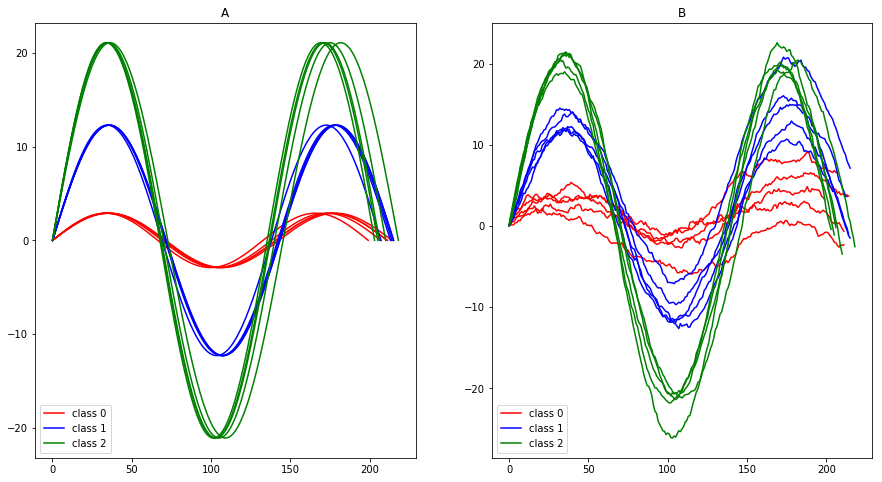

In [112]:
colors = ['red', 'blue', 'green']
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
for c, p, p_eps in zip(classes, X, X_perturbed):
    ax[0].plot(p, c=colors[c], label = f'class {c}' if f'class {c}' not in plt.gca().get_legend_handles_labels()[1] else '')
    ax[1].plot(p_eps, c=colors[c], label = f'class {c}' if f'class {c}' not in plt.gca().get_legend_handles_labels()[1] else '')
ax[0].legend()
ax[0].set_title('A')
ax[1].legend()
ax[1].set_title('B')
plt.show()

In [11]:
classes

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]

In [12]:
X_clustering = [x[::resampling_rate] for x in X_perturbed]

# Clustering: DTW

In [67]:
dist = 'eucl'

if dist == 'eucl':
    # Euclidean
    d = lambda a, b: np.sum([x**2 for x in (a-b)])
    f_d = lambda DD, a, b: np.sqrt(DD**2 + d(a, b))
    final_operator = lambda x: np.sqrt(x)

elif dist == 'manh':
    # Manhattan
    d = lambda a, b : np.abs(a-b)
    f_d = lambda DD, a, b: DD + d(a,b)
    final_operator = lambda x: x

else:
    # Minkowksi
    d = lambda a, b : np.abs(a-b)
    f_d = lambda DD, a, b: max(DD, d(a,b))
    final_operator = lambda x: x

### Precompute pairwise distances matrix

In [68]:
dtw_pairwise_dist = {}
for i_p, p in tqdm(enumerate(X_perturbed), total=len(classes)):
    inner_dtw_dict = {}
    for i_q, q in enumerate(X_perturbed[i_p:]):
        inner_dtw_dict[i_p+i_q] = Warp(p, q, d, f_d, final_operator, plot_2d=True).cost
    dtw_pairwise_dist[i_p] = inner_dtw_dict

In [69]:
df_dtw = pd.DataFrame.from_dict(dtw_pairwise_dist).fillna(0.) + pd.DataFrame.from_dict(dtw_pairwise_dist).fillna(0.).T 

### K-Menoids Clustering

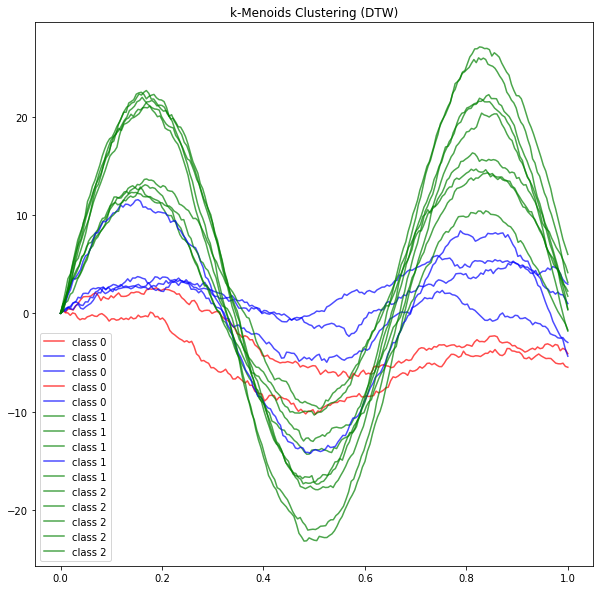

In [32]:
# compute clusters and menoids (centers)
k_menoids_clusters, k_menoids_centers = cluster(df_dtw.values, k=3)

# colors map
k_men_cluster_to_colors_dict = {}
for k, c in enumerate(np.unique(k_menoids_clusters)):
    k_men_cluster_to_colors_dict[c] = colors[k]
    
plt.figure(figsize=(10,10))
for k, (path, cluster_index, class_index) in enumerate(zip(X_perturbed, k_menoids_clusters, classes)):
    plt.plot(np.linspace(0, 1, len(path)), path, color=k_men_cluster_to_colors_dict[cluster_index], 
             label=f'class {class_index}', alpha=0.7)
plt.legend()
plt.title('k-Menoids Clustering (DTW)')
plt.show()

### Agglomerative Clustering

In [49]:
# dtw_aggl_cluster = AgglomerativeClustering(n_clusters=3, affinity='precomputed', 
#                                            linkage='single',
# #                                            linkage='complete', 
# #                                            linkage='average'
#                                            )
# dtw_aggl_cluster.fit(df_dtw.values)

In [50]:
# # colors map
# aggl_cluster_to_colors_dict = {}
# for k, c in enumerate(np.unique(dtw_aggl_cluster.labels_)):
#     aggl_cluster_to_colors_dict[c] = colors[k]

In [51]:
# plt.figure(figsize=(10,10))
# for k, (path, cluster_index, class_index) in enumerate(zip(X_perturbed, dtw_aggl_cluster.labels_, classes)):
#     plt.plot(np.linspace(0,1, len(path)), path, color=aggl_cluster_to_colors_dict[cluster_index], 
#              label=f'class {class_index}', alpha=0.7)
# plt.legend()
# plt.title('Agglomerative Clustering (DTW)')
# plt.show()

### Spectral Clustering

In [52]:
# dtw_spectral_cluster = SpectralClustering(n_clusters=3, affinity='precomputed')

# dtw_spectral_cluster.fit(df_dtw.values)

# # colors map
# spectral_cluster_to_colors_dict = {}
# for k, c in enumerate(np.unique(dtw_spectral_cluster.labels_)):
#     spectral_cluster_to_colors_dict[c] = colors[k]

# # plotting
# plt.figure(figsize=(10,10))
# for k, (path, cluster_index, class_index) in enumerate(zip(X_perturbed, dtw_spectral_cluster.labels_, classes)):
#     plt.plot(np.linspace(0,1, len(path)), path, color=spectral_cluster_to_colors_dict[cluster_index], 
#              label=f'class {class_index}', alpha=0.7)
# plt.legend()
# plt.title('Spectral Clustering (DTW)')
# plt.show()

### Multidimensional Scale Clustering

In [95]:
# embedding = MDS(n_components=3, dissimilarity='precomputed')

# XX = ((1-(df_dtw - df_dtw.values.min()))/(df_dtw.values.max()-df_dtw.values.min())).values

# MDS_results = embedding.fit_transform(XX)

# traces = []
# for i, l in enumerate(np.unique(classes)):
#     indices = [ind for ind in range(len(classes)) if classes[ind]==l]
#     trace = go.Scatter3d(x=MDS_results[indices,0], 
#                          y=MDS_results[indices,1], 
#                          z=MDS_results[indices,2],
#                          mode='markers+text', 
#                          text='digit: {}'.format(l),
#                          marker=dict(size=10, line=dict(color=colors[i], width=0.8),opacity=0.8)
#                          )
#     traces.append(trace)
    
# data = traces
# layout = go.Layout(title='Multidimensional scaling clustering using DTW distance')
# fig = dict(data=data, layout=layout)
# plotly.offline.plot(fig, filename = 'DTW_Mult_scale.html')

### PCA

In [94]:
# pca = decomposition.PCA()
# pca.n_components = 3
# # PCA_results = pca.fit_transform(XX)
# PCA_results = pca.fit_transform(df_dtw)

# traces = []
# for i, l in enumerate(np.unique(classes)):
#     indices = [ind for ind in range(len(classes)) if classes[ind]==l]
#     trace = go.Scatter3d(x=PCA_results[indices,0], 
#                          y=PCA_results[indices,1], 
#                          z=PCA_results[indices,2],
#                          mode='markers+text', 
#                          text='digit: {}'.format(l),
#                          marker=dict(size=10, line=dict(color=colors[i], width=0.8),opacity=0.8)
#                          )
#     traces.append(trace)
    
# data = traces
# layout = go.Layout(title='PCA Clustering using DTW distance')
# fig = dict(data=data, layout=layout)
# plotly.offline.plot(fig, filename = 'DTW_PCA.html')

### TSNE

In [97]:
pca = decomposition.PCA()
pca.n_components = 3
PCA_results = pca.fit_transform(df_dtw)

X_embedded_dtw = TSNE(n_components=3, 
                     perplexity=3,
                     early_exaggeration=20,
                     learning_rate=200,
                     init=PCA_results,
                     metric='precomputed').fit_transform(df_dtw.values)


traces = []
for i, l in enumerate(np.unique(classes)):
    indices = [ind for ind in range(len(classes)) if classes[ind]==l]
    trace = go.Scatter3d(x=X_embedded_dtw[indices,0], 
                         y=X_embedded_dtw[indices,1], 
                         z=X_embedded_dtw[indices,2],
                         mode='markers+text', 
                         text='digit: {}'.format(l),
                         marker=dict(size=8, line=dict(color=colors[i], width=0.8),opacity=0.8)
                         )
    traces.append(trace)
    
data = traces
layout = go.Layout(title='t-SNE Embedding using DTW distance')
fig = dict(data=data, layout=layout)
plotly.offline.plot(data, filename = 'DTW_tSNE.html')

'file://C:\\Users\\Cristopher\\source\\repos\\crispitagorico\\warped-p-variation\\Branch-and-Bound\\examples\\DTW_tSNE.html'

# Clustering: Warped rough p-variation distance

In [13]:
p_var = 2.3
sig_depth = 2

In [14]:
X_clustering_addtime = AddTime().fit_transform(X_clustering)

### Test on one couple of paths

In [15]:
x = X_clustering_addtime[0].astype(np.float64)

In [16]:
y = X_clustering_addtime[1].astype(np.float64)

In [27]:
problem = BnBWarping(x=x, y=y, p=p_var, depth=sig_depth, norm='l1', root_node=(0,0), 
                     bc=5, plot_2d=True, pvar_dist_mem=None, cache_size=3000, 
                     allow_randomization=True, min_step=2, max_step=3)

tolerance = 1e-2

# solution via BnB algo
results = pybnb.Solver().solve(problem, 
                               log=None, 
                               queue_tolerance=tolerance, 
                               absolute_gap=tolerance, 
                               objective_stop=tolerance, 
                               comparison_tolerance=tolerance, 
                               branch_tolerance=tolerance, 
                               
#                                queue_strategy='objective'
#                                queue_strategy='bound', 
#                                queue_strategy='breadth',
                               queue_strategy=['depth', 'random'],
#                                queue_strategy='depth',
#                                queue_strategy='local_gap',
#                                queue_strategy='fifo',
#                                queue_strategy='lifo',
                               
                               time_limit=150,
#                                node_limit=10,
#                                queue_limit=100,
                               )

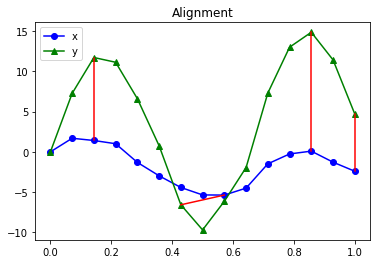

In [29]:
best_warp = results.best_node.state
_, optimal_partition = problem.distance(results.best_node.state, optim_partition=True)
problem.plot_alignment([best_warp[k] for k in optimal_partition])
plt.show()

### Pre-computing distance matrix

In [30]:
rough_warping_pairwise_dist = {}
rough_warp_problem = {}
rough_warp_solution = {}

for i_p, p in tqdm(enumerate(X_clustering_addtime), total=len(classes)):
    
    inner_rough_warping_dict = {}
    inner_prob = {}
    inner_soln = {}
    
    for i_q, q in tqdm(enumerate(X_clustering_addtime[i_p:]), total=len(X_clustering_addtime[i_p:])):
        
        # define problem
        problem = BnBWarping(x=p, y=q, p=p_var, depth=sig_depth, norm='l1', root_node=(0,0), bc=5, plot_2d=True, 
                             pvar_dist_mem=None, cache_size=3000, allow_randomization=True, min_step=2, max_step=3)
        
        # solution via BnB algo
        results = pybnb.Solver().solve(problem, 
                                       log=None, 
                                       queue_tolerance=tolerance, 
                                       absolute_gap=tolerance, 
                                       objective_stop=tolerance, 
                                       comparison_tolerance=tolerance, 
                                       branch_tolerance=tolerance, 

#                                        queue_strategy='objective'
#                                        queue_strategy='bound', 
#                                        queue_strategy='breadth',
                                       queue_strategy=['depth', 'random'],
#                                        queue_strategy='depth',
#                                        queue_strategy='local_gap',
#                                        queue_strategy='fifo',
#                                        queue_strategy='lifo',

                                       time_limit=150,
#                                        node_limit=10,
#                                        queue_limit=100,
                                       )
        
        # store results
        inner_rough_warping_dict[i_p+i_q] = results.objective
        inner_prob[i_p+i_q] = problem
        inner_soln[i_p+i_q] = results
        
    rough_warping_pairwise_dist[i_p] = inner_rough_warping_dict
    rough_warp_problem[i_p] = inner_prob
    rough_warp_solution[i_p] = inner_soln

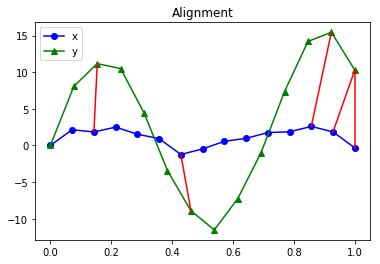

In [31]:
i = 4
j = 7

problem = rough_warp_problem[i][j]
results = rough_warp_solution[i][j]

best_warp = results.best_node.state
_, optimal_partition = problem.distance(results.best_node.state, optim_partition=True)
problem.plot_alignment([best_warp[k] for k in optimal_partition])
plt.show()

In [32]:
df_rough_warping = pd.DataFrame.from_dict(rough_warping_pairwise_dist).fillna(0.) \
                   + pd.DataFrame.from_dict(rough_warping_pairwise_dist).fillna(0.).T

In [33]:
df_rough_warping

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.000000,29.244531,26.156422,47.054286,25.396421,329.952999,366.496111,357.604892,321.310347,284.810362,1087.122511,1038.189506,1077.257641,870.954742,996.638617
1,29.244531,0.000000,25.450514,25.797529,35.759955,320.448879,356.801986,341.038382,302.334146,269.103328,1075.564658,1027.706806,1066.085424,861.237630,984.394139
2,26.156422,25.450514,0.000000,29.626794,29.262102,334.841664,371.202960,356.748254,318.876868,284.927589,1090.775066,1041.930463,1080.579813,876.059835,999.125909
3,47.054286,25.797529,29.626794,0.000000,42.004717,332.529423,369.512183,347.802468,307.529159,277.402180,1085.672229,1038.320197,1075.874848,872.848685,994.056635
4,25.396421,35.759955,29.262102,42.004717,0.000000,352.604942,388.344886,376.121074,337.092618,302.986272,1109.042790,1060.458753,1099.286951,892.508806,1018.042523
5,329.952999,320.448879,334.841664,332.529423,352.604942,0.000000,99.080038,150.961342,161.668271,107.731086,758.587244,710.292091,750.334354,548.317950,670.828882
6,366.496111,356.801986,371.202960,369.512183,388.344886,99.080038,0.000000,164.131479,158.293542,127.930611,726.792651,680.149410,721.744162,523.711054,640.748824
7,357.604892,341.038382,356.748254,347.802468,376.121074,150.961342,164.131479,0.000000,133.016041,135.965787,748.875541,706.186345,739.156182,598.886973,654.170748
8,321.310347,302.334146,318.876868,307.529159,337.092618,161.668271,158.293542,133.016041,0.000000,91.885550,802.415498,767.880439,800.245854,602.367744,712.940686
9,284.810362,269.103328,284.927589,277.402180,302.986272,107.731086,127.930611,135.965787,91.885550,0.000000,814.644038,772.557562,808.545875,614.367308,723.953510


In [59]:
# mask = df_rough_warping != np.inf
# df_rough_warping = df_rough_warping[mask].fillna(df_rough_warping[mask].fillna(0.).values.max())

In [34]:
df_rough_warping.to_csv('../../data/rough_warping_pairwise_distances_p_{}.csv'.format(p_var))

### K-medoids clustering

In [35]:
# compute clusters and menoids (centers)
k_menoids_clusters, k_menoids_centers = cluster(df_rough_warping.values, k=3)

In [36]:
# colors map
k_men_cluster_to_colors_dict = {}
for k, c in enumerate(np.unique(k_menoids_clusters)):
    k_men_cluster_to_colors_dict[c] = colors[k]

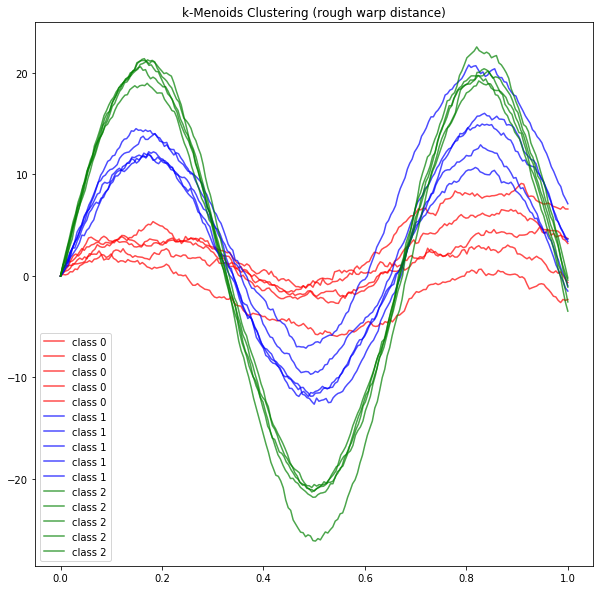

In [100]:
plt.figure(figsize=(10,10))
for k, (path, cluster_index, class_index) in enumerate(zip(X_perturbed, k_menoids_clusters, classes)):
    plt.plot(np.linspace(0,1, len(path)), path, color=k_men_cluster_to_colors_dict[cluster_index], 
             label=f'class {class_index}', alpha=0.7)
plt.legend()
plt.title('k-Menoids Clustering (rough warp distance)')
plt.show()

### Spectral Clustering

In [53]:
# rough_warp_spectral_cluster = SpectralClustering(n_clusters=3, affinity='precomputed')
# rough_warp_spectral_cluster.fit(df_rough_warping.values)

# # colors map
# spectral_cluster_to_colors_dict = {}
# for k, c in enumerate(np.unique(rough_warp_spectral_cluster.labels_)):
#     spectral_cluster_to_colors_dict[c] = colors[k]

# plt.figure(figsize=(10,10))
# for k, (path, cluster_index, class_index) in enumerate(zip(X_perturbed, rough_warp_aggl_cluster.labels_, classes)):
#     plt.plot(np.linspace(0,1, len(path)), path, color=spectral_cluster_to_colors_dict[cluster_index], 
#              label=f'class {class_index}', alpha=0.7)
# plt.legend()
# plt.title('Spectral Clustering')
# plt.show()

### Agglomerative Clustering

In [107]:
# rough_warp_aggl_cluster = AgglomerativeClustering(n_clusters=3, affinity='precomputed', 
#                                                   linkage='single',
# #                                                   linkage='complete', 
# #                                                   linkage='average',
#                                                  )
# rough_warp_aggl_cluster.fit(df_rough_warping.values)

# # colors map
# aggl_cluster_to_colors_dict = {}
# for k, c in enumerate(np.unique(rough_warp_aggl_cluster.labels_)):
#     aggl_cluster_to_colors_dict[c] = colors[k]
    
# plt.figure(figsize=(10,10))
# for k, (path, cluster_index, class_index) in enumerate(zip(X_perturbed, rough_warp_aggl_cluster.labels_, classes)):
#     plt.plot(np.linspace(0,1, len(path)), path, color=aggl_cluster_to_colors_dict[cluster_index], 
#              label=f'class {class_index}', alpha=0.7)
# plt.legend()
# plt.title('Agglomerative Clustering')
# plt.show()

### Multidimensional Scale Clustering

In [87]:
# embedding = MDS(n_components=3, dissimilarity='precomputed')

# XX = ((1-(df_rough_warping - df_rough_warping.values.min()))/(df_rough_warping.values.max()-df_rough_warping.values.min())).values

# MDS_results = embedding.fit_transform(XX)

# traces = []
# for i, l in enumerate(np.unique(classes)):
#     indices = [ind for ind in range(len(classes)) if classes[ind]==l]
#     trace = go.Scatter3d(x=MDS_results[indices,0], 
#                          y=MDS_results[indices,1], 
#                          z=MDS_results[indices,2],
#                          mode='markers+text', 
#                          text='digit: {}'.format(l),
#                          marker=dict(size=10, line=dict(color=colors[i], width=0.8),opacity=0.8)
#                          )
#     traces.append(trace)

# data = traces
# layout = go.Layout(title='Multidimensional scaling clustering using rough warping distance')
# fig = dict(data=data, layout=layout)
# plotly.offline.plot(fig, filename = 'RoughWarp_Mult_scale.html')

### PCA

In [96]:
# # XX = ((1-(df_rough_warping - df_rough_warping.values.min()))/(df_rough_warping.values.max()-df_rough_warping.values.min())).values

# pca = decomposition.PCA()
# pca.n_components = 3
# # PCA_results = pca.fit_transform(XX)
# PCA_results = pca.fit_transform(df_rough_warping.values)

# traces = []
# for i, l in enumerate(np.unique(classes)):
#     indices = [ind for ind in range(len(classes)) if classes[ind]==l]
#     trace = go.Scatter3d(x=PCA_results[indices,0], 
#                          y=PCA_results[indices,1], 
#                          z=PCA_results[indices,2],
#                          mode='markers+text', 
#                          text='digit: {}'.format(l),
#                          marker=dict(size=10, line=dict(color=colors[i], width=0.8),opacity=0.8)
#                          )
#     traces.append(trace)

# data = traces
# layout = go.Layout(title='PCA Clustering using rough warping distance')
# fig = dict(data=data, layout=layout)
# plotly.offline.plot(fig, filename = 'RoughWarp_PCA.html')

### TSNE

In [105]:
pca = decomposition.PCA()
pca.n_components = 3
PCA_results = pca.fit_transform(df_rough_warping)

X_embedded_rough_warp = TSNE(n_components=3, 
                             perplexity=3,
                             early_exaggeration=20,
                             learning_rate=200,
                             init=PCA_results,
                             metric='precomputed').fit_transform(df_rough_warping.values)

traces = []
colors = ['red', 'blue', 'green']
for i, l in enumerate(np.unique(classes)):
    indices = [ind for ind in range(len(classes)) if classes[ind]==l]
    trace = go.Scatter3d(x=X_embedded_rough_warp[indices,0], 
                         y=X_embedded_rough_warp[indices,1], 
                         z=X_embedded_rough_warp[indices,2],
                         mode='markers+text', 
                         text='digit: {}'.format(l),
                         marker=dict(size=6, line=dict(color=colors[i], width=0.5),opacity=0.8),
                         )
    traces.append(trace)

data = traces
layout = go.Layout(title='t-SNE using rough warping distance',)
fig = dict(data=data, layout=layout)
plotly.offline.plot(data, filename = 'RoughWarp_tSNE.html')

'file://C:\\Users\\Cristopher\\source\\repos\\crispitagorico\\warped-p-variation\\Branch-and-Bound\\examples\\RoughWarp_tSNE.html'